**Parameters to reproduce the paper's results**:
* change the optimizer from SGD to Adam in `lib/models.py`,
* change the size of the vocabulary from 1000 to 10000 in `train.keep_top_words()` below.

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.sparse
import numpy as np
import time

%matplotlib inline

In [2]:
flags = tf.app.flags
tf.app.flags.DEFINE_string('f', '', 'kernel')
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 16, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'cosine', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 0, 'Number of coarsened graphs.')

flags.DEFINE_string('dir_data', os.path.join('..', 'data', '20news'), 'Directory to store data.')
flags.DEFINE_integer('val_size', 400, 'Size of the validation set.')

# Data

In [3]:
# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
train = utils.Text20News(data_home=FLAGS.dir_data, subset='train', remove=remove)

# Pre-processing: transform everything to a-z and whitespace.
print(train.show_document(1)[:400])
train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])

N = 11314 documents, C = 20 classes
document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00

N = 11314 documents, M = 72607 words, sparsity=0.0852%
    480 documents in class  0 (alt.atheism)
    584 documents in class  1 (comp.graphics)
    591 documents in class  2 (comp.os.ms-windows.misc)
    590 documents in class  3 (comp.sys.ibm.pc.hardware)
    578 documents in class  4 (comp.sys.mac.hardware)
    593 documents in class  5 (comp.windows.x)
    585 documents in class  6 (misc.forsale)
    594 documents in class  7 (rec.autos)
    598 documents in class  8 (rec.motorcycles)
    597 documents in class  9 (rec.sport.baseball)
    600 documents in class 10 (rec.sport.hockey)
    595 documents in class 11 (sci.crypt)
    591 documents in class 12 (sci.electronics)
    594 documents in class 13 (sci.med)
    593 documents in class 14 (sci.space)
    599 documents in class 15 (soc.religion.christian)
    546 documents in class 16 (talk.politics.guns)
    564 documents in class 17 (talk.politics.mideast)
    465 documents in class 18 (talk.politics.misc)
    377 documents in cl

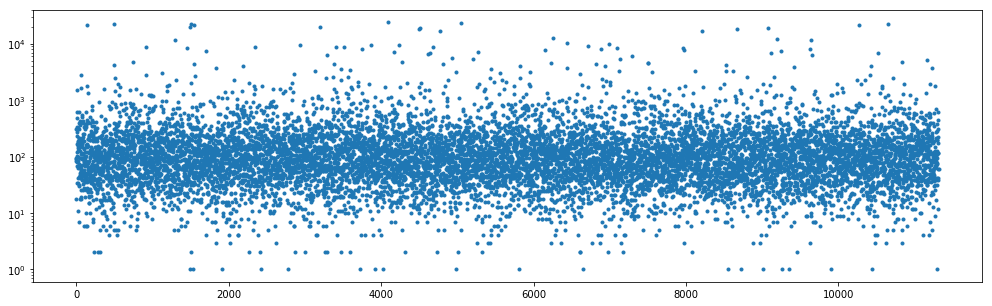

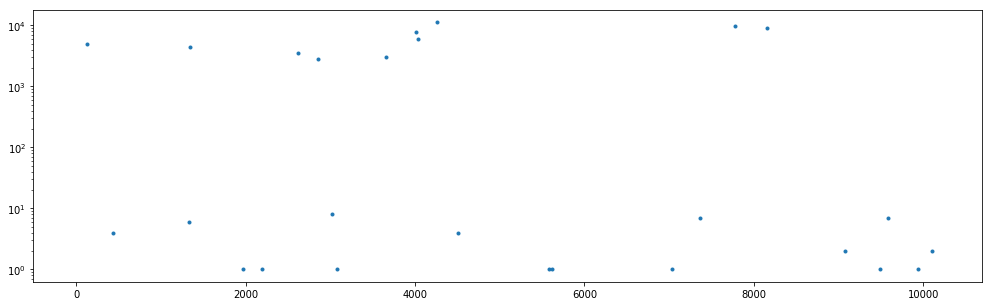

In [4]:
# Remove short documents.
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train.vocab.index('ax')
    wc = train.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc
wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [5]:
# Word embedding
if True:
    train.embed()
else:
    train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train.data_info()
# Further feature selection. (TODO)

ValueError: You must provide only one of singlestream or corpus_file arguments.

In [ ]:
# Feature selection.
# Other options include: mutual information or document count.
freq = train.keep_top_words(1000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

In [ ]:
train.normalize(norm='l1')
train.show_document(1);

In [ ]:
# Test dataset.
test = utils.Text20News(data_home=FLAGS.dir_data, subset='test', remove=remove)
test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

In [ ]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

#del train, test

# Feature graph

In [ ]:
t_start = time.process_time()
dist, idx = graph.distance_sklearn_metrics(graph_data, k=FLAGS.number_edges, metric=FLAGS.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

In [ ]:
t_start = time.process_time()
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

# Classification

In [ ]:
# Training set is shuffled already.
#perm = np.random.permutation(train_data.shape[0])
#train_data = train_data[perm,:]
#train_labels = train_labels[perm]

# Validation set.
if False:
    val_data = train_data[:FLAGS.val_size,:]
    val_labels = train_labels[:FLAGS.val_size]
    train_data = train_data[FLAGS.val_size:,:]
    train_labels = train_labels[FLAGS.val_size:]
else:
    val_data = test_data
    val_labels = test_labels

In [ ]:
if True:
    utils.baseline(train_data, train_labels, test_data, test_labels)

In [ ]:
common = {}
common['dir_name']       = '20news/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(train_labels) + 1  # number of classes

model_perf = utils.model_perf()

In [ ]:
if True:
    name = 'softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 1e3
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fc_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.95
    params['momentum']       = 0.9
    params['F']              = []
    params['K']              = []
    params['p']              = []
    params['M']              = [2500, 500, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'fgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'fourier'
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.001
    params['decay_rate']     = 1
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [L[0].shape[0]]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'sgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['filter']         = 'spline'
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 1e-3
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [32]
    params['K']              = [5]
    params['p']              = [1]
    params['M']              = [C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
if True:
    name = 'cgconv_fc_softmax'
    params = common.copy()
    params['dir_name'] += name
    params['regularization'] = 0
    params['dropout']        = 1
    params['learning_rate']  = 0.1
    params['decay_rate']     = 0.999
    params['momentum']       = 0
    params['F']              = [5]
    params['K']              = [15]
    params['p']              = [1]
    params['M']              = [100, C]
    model_perf.test(models.cgcnn(L, **params), name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [ ]:
model_perf.show()

In [ ]:
if False:
    grid_params = {}
    data = (train_data, train_labels, val_data, val_labels, test_data, test_labels)
    utils.grid_search(params, grid_params, *data, model=lambda x: models.cgcnn(L,**x))